In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [4]:
import torchvision.transforms as transforms

all_batches_data = []
all_batches_labels = []

# Define normalization transform as in file_context_0
transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 stats
])

for i in range(1, 6):
    with open(f'generative/autoencoders/data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32) / 255.
# Apply normalization as a torchvision transform
data = transform(data)
data = data.to(device)
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

In [5]:
print(x_train.shape)
print(x_train.device)

torch.Size([40000, 3, 32, 32])
mps:0


In [6]:
class ConvNet(nn.Module):
    def __init__(self, 
                 num_channels: int, 
                 num_classes: int, 
                 filters: list[int], 
                 activation: nn.Module = nn.ReLU
                 ):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                nn.Conv2d(filters[i], filters[i+1], kernel_size=3, stride=2, padding=1), 
                nn.BatchNorm2d(filters[i+1]),
                activation()
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv_layers(x)
        return self.flatten(h)


In [7]:
model = ConvNet(3, 10, [64, 128, 256, 512, 1024], nn.LeakyReLU).to(device)


In [8]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affin

In [ ]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn, all_valid_loss):
    model.eval()
    valid_loss = []
    valid_acc = []
    
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    all_valid_loss.append(sum(valid_loss) / len(valid_loss))
    
    return sum(valid_acc) / len(valid_acc)

def train_model(model: nn.Module,
                optim: torch.optim.Optimizer,
                loss_fn,
                train_loader,
                valid_loader,
                scheduler,
                epochs=10,
                batch_size=32,
                valid_every=1
                ):
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        scheduler.step()
        
        if epoch % valid_every == 0:
            valid_acc = validate_model(model, valid_loader, loss_fn, all_valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)


In [13]:
from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=True)

In [14]:
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
loss_fn = nn.CrossEntropyLoss()


train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=10, valid_every=1)

NameError: name 'accuracy' is not defined

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1
                 ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            activation(),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), 
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1, 
                 dropout: float = 0.2
                 ):
        super().__init__()
        self.conv1 = ConvBlock(
            in_channels, 
            out_channels, 
            activation, 
            kernel_size, 
            stride, 
            padding
        )
        if in_channels == out_channels:
            self.idconv = nn.Identity()
        else:
            self.idconv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        
        self.avgpool = nn.Identity() if stride == 1 else nn.AvgPool2d(kernel_size=2, stride=stride)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        h = self.conv1(x)
        h_id = self.avgpool(self.idconv(x))
        return self.dropout(self.activation(h + h_id))



In [ ]:
res_block = ResBlock(3, 64).to(device)
print(x_train[0].shape)
res_block(x_train[0].unsqueeze(0)).shape

for i in range(10):
    print(res_block(x_train[i].unsqueeze(0)).shape)


torch.Size([3, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])


In [ ]:
class ResNet(nn.Module):
    def __init__(self,
                 num_channels: int,
                 num_classes: int,
                 filters: list[int],
                 activation: nn.Module = nn.ReLU,
                 stride: int = 2,
                 dropout: float = 0.2
                 ):
        super().__init__()
        res_layers = [
            ResBlock(num_channels, filters[0], activation, stride=1)
        ]
        for i in range(len(filters)-1):
            res_layers += [
                ResBlock(filters[i], filters[i+1], activation, stride=stride, dropout=dropout)
            ]
        self.res_layers = nn.Sequential(*res_layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(filters[-1], num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
            activation()
        )
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        for _, layer in enumerate(self.res_layers):
            x = layer(x)

        h = self.avgpool(x)
        h = self.flatten(h)
        h = self.dropout(h)
        return self.linear(h)


In [ ]:
model2 = ResNet(3, 10, [64, 128, 256, 256, 512], nn.ReLU, stride=2).to(device)
model2

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (avgpool): Identity()
      (activation): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): ReLU()
          (4

In [ ]:
print(model.parameters())
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print(model2.parameters())
total_params = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters: {total_params}")



<generator object Module.parameters at 0x35723b370>
Number of parameters: 6366730
<generator object Module.parameters at 0x35723b300>
Number of parameters: 6047706


Epoch 0, Train Loss: 1.7264918119381791, Valid Loss: 1.722223167177997, Acc: 0.4113923907279968
Epoch 1, Train Loss: 1.4273258695206321, Valid Loss: 1.2788734375676023, Acc: 0.5679391026496887
Epoch 2, Train Loss: 1.159340348297034, Valid Loss: 1.2844410184063488, Acc: 0.5622033476829529
Epoch 3, Train Loss: 0.9338847888163484, Valid Loss: 4.508389116842536, Acc: 0.11075949668884277
Epoch 4, Train Loss: 0.7455906932727216, Valid Loss: 1.535502479046206, Acc: 0.49792325496673584
Epoch 5, Train Loss: 0.6193622658237482, Valid Loss: 0.924779517741143, Acc: 0.6878955960273743
Epoch 6, Train Loss: 0.5052872536281428, Valid Loss: 0.8039785812172708, Acc: 0.7370451092720032
Epoch 7, Train Loss: 0.37489700436401674, Valid Loss: 0.748811739909498, Acc: 0.7620648741722107
Epoch 8, Train Loss: 0.2529268436871778, Valid Loss: 0.733550296176838, Acc: 0.7764042615890503
Epoch 9, Train Loss: 0.16346507288586978, Valid Loss: 0.6854338517671899, Acc: 0.7982594966888428
Epoch 10, Train Loss: 0.112061078

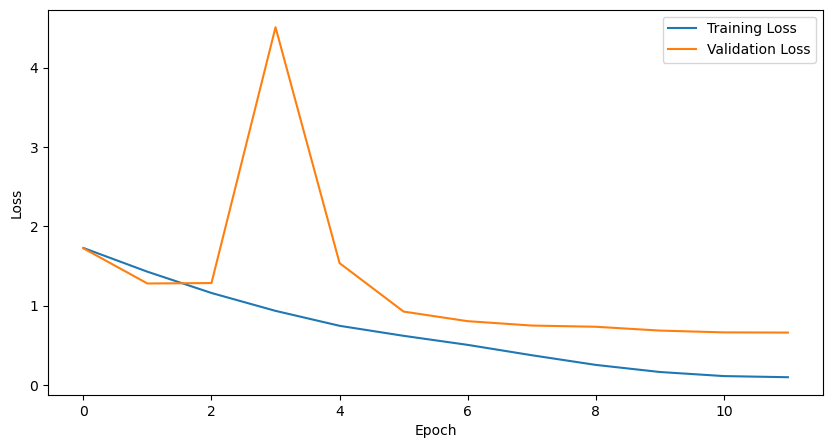

In [ ]:
optim2 = torch.optim.Adam(model2.parameters(), lr=0.005, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optim2, max_lr=0.005, total_steps=12)
loss_fn = nn.CrossEntropyLoss()
train_model(model2, optim2, loss_fn, train_dl, valid_dl, scheduler=scheduler2, epochs=12, valid_every=1)

Since the model incorporates information from each resblock input into its output, you can make the model deeper and wider while improving learning and not losing too much information along the critical path. 

The resnet with less parameters 6M vs 6.5M still performs better on the validation set than the regular convnet. The resnet gets upto 85.5% accuracy vs 76.1% for the convnet. 

When we give the resnet as much width as out convnet, the number fo parameters rises to 19.5M. The improvement in validation accuracy, however, was marginal (85.9% vs 85.5%). 


Dropout strategy results (evalutated with the 6M parameter ResNet w/ same hyperparameters): 
1. Place after each conv block: 86% 
2. Place after each resblock: 87% -- loss still decreasing, we can still train more 
3. Place before the linear layer 85% 
4. After each resblock & before linear layer: 87.23%

## Testing the resnet from the src library

We moved the resnets and related blocks to a separate file and imported them here. We also made a few changes like using pre-activation resnets and group normalization. 

Epoch 0, Train Loss: 1.8806572143262186, Valid Loss: 1.6085679500917844, Acc: 0.44966375827789307
Epoch 1, Train Loss: 1.5427988184907566, Valid Loss: 1.441557076912892, Acc: 0.5097903609275818
Epoch 2, Train Loss: 1.2642108261013945, Valid Loss: 1.5224783420562744, Acc: 0.5048457384109497
Epoch 3, Train Loss: 1.033171859793008, Valid Loss: 1.0985784032676793, Acc: 0.6314280033111572
Epoch 4, Train Loss: 0.860329389000853, Valid Loss: 0.9354499201231365, Acc: 0.6792919039726257
Epoch 5, Train Loss: 0.7182766775163217, Valid Loss: 0.8653265486789655, Acc: 0.718156635761261
Epoch 6, Train Loss: 0.5934921510684223, Valid Loss: 0.6954501120350028, Acc: 0.7639438509941101
Epoch 7, Train Loss: 0.45694566144349097, Valid Loss: 0.6172300215008892, Acc: 0.7963805198669434
Epoch 8, Train Loss: 0.33046006723143423, Valid Loss: 0.6342311014857474, Acc: 0.7927215099334717
Epoch 9, Train Loss: 0.2124898257537391, Valid Loss: 0.6265504722353779, Acc: 0.8071597814559937
Epoch 10, Train Loss: 0.1407927

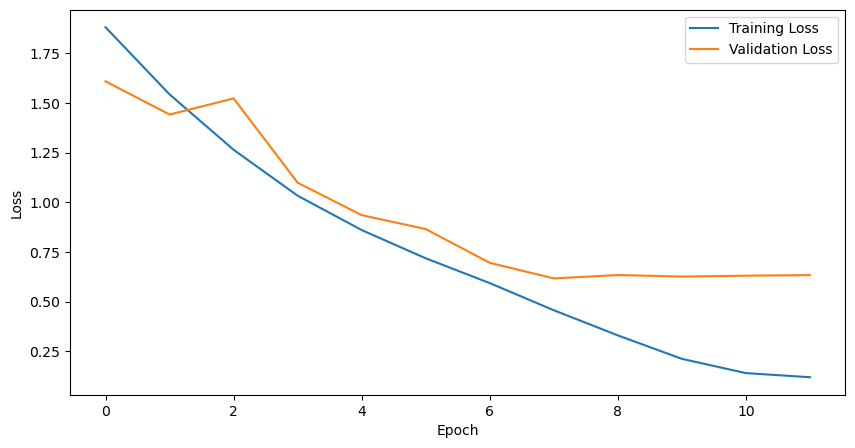

In [ ]:
import src.resnet as src_resnet

model3 = src_resnet.ResNet(3, 10, [64, 128, 256, 256, 512], nn.ReLU, stride=2).to(device)
optim3 = torch.optim.Adam(model3.parameters(), lr=0.005, weight_decay=1e-5)
scheduler3 = torch.optim.lr_scheduler.OneCycleLR(optim3, max_lr=0.005, total_steps=12)
loss_fn = nn.CrossEntropyLoss()
train_model(model3, optim3, loss_fn, train_dl, valid_dl, scheduler=scheduler3, epochs=12, valid_every=1)
